In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s,a)+\gamma\max_{a'}Q(s',a')-Q(s,a))$$

In [2]:
def GridLine(col,row):
    ax = plt.gca();
    # Major ticks
    ax.set_xticks(np.arange(0, col, 1));
    ax.set_yticks(np.arange(0, row, 1));
    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, col+1, 1));
    ax.set_yticklabels(np.arange(1, row+1, 1));
    # Minor ticks
    ax.set_xticks(np.arange(-.5, col, 1), minor=True);
    ax.set_yticks(np.arange(-.5, row, 1), minor=True);
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    return ax
aUp = 0; aDown = 1; aLeft = 2; aRight = 3;
class World():
    def __init__(self,mode):
        self.mode = mode
    def getParamSet(self):
        if self.mode == 'small':
            paramSet = self.getsmall()
        elif self.mode == 'grid':
            paramSet = self.getgrid()
        elif self.mode == 'cliff':
            paramSet = self.getcliff()
        return paramSet
    def getsmall(self):
        paramSet = dict()
        paramSet['rowCount'] = 4; paramSet['colCount'] = 4;
        paramSet['obsSet'] = np.array([[1,1],[2,1],[1,2]])
        paramSet['startState'] = np.array([0,0])
        paramSet['goalState'] = np.array([3,3])
        paramSet['badSet'] = np.array([])
        paramSet['pGoodTrans'] = .8; paramSet['bias'] = .5
        paramSet['rStep']=-1; paramSet['rGoal']=10
        paramSet['rBad'] = -6; paramSet['gamma'] = .9
        return paramSet
    def getgrid(self):
        paramSet = dict()
        paramSet['rowCount'] = 9; paramSet['colCount'] = 12;
        paramSet['obsSet'] = np.array([[8,6],[7,6],[6,6],
                                      [5,6],[4,6],[3,6],
                                      [3,7],[3,8],[3,9]])
        paramSet['startState'] = np.array([0,1])
        paramSet['goalState'] = np.array([7,8])
        paramSet['badSet'] = np.array([[2,1]])
        paramSet['pGoodTrans'] = .7; paramSet['bias'] = .5
        paramSet['rStep']=-1; paramSet['rGoal']=10
        paramSet['rBad'] = -6; paramSet['gamma'] = .9
        return paramSet
    def getcliff(self):
        paramSet = dict()
        paramSet['rowCount'] = 5; paramSet['colCount'] = 10;
        paramSet['obsSet'] = np.array([[0,9],[1,9],[2,9],
                                      [3,9],[4,9]])
        paramSet['startState'] = np.array([4,0])
        paramSet['goalState'] = np.array([4,8])
        paramSet['badSet'] = np.array([[4,1],[4,2],[4,3],[4,4],
                                      [4,5],[4,6],[4,7]])
        paramSet['pGoodTrans'] = 1; paramSet['bias'] = 0
        paramSet['rStep']=-1; paramSet['rGoal']=10
        paramSet['rBad'] =-100; paramSet['gamma'] = .9
        return paramSet
def getDir(a,ang):
    leftLUT = np.array([2,3,1,0])
    rightLUT = np.array([3,2,0,1])
    if ang == 0:
        Dir = a
    elif ang == -1:
        Dir = leftLUT[a]
    elif ang == 1:
        Dir = rightLUT[a]
    return Dir
def getState(s,Dir,paramSet):
    cLUT = np.array([0,0,-1,1])
    rLUT = np.array([-1,1,0,0])
    rc = np.array(np.unravel_index(s,
                    (paramSet['rowCount'],paramSet['colCount'])))
    rc[0] = rc[0] + rLUT[Dir]
    rc[1] = rc[1] + cLUT[Dir]
    
    cond1 = np.any(rc<0)
    cond2 = np.any(rc[0]>paramSet['rowCount']-1)
    cond3 = np.any(rc[1]>paramSet['colCount']-1)
    cond4 = np.any(np.sum(np.abs(
        paramSet['obsSet']-
        np.tile(rc,(paramSet['obsSet'].shape[0],1))),1) ==0)
    
    if cond1 or cond2 or cond3 or cond4:
        sout = s
    else:
        sout = np.ravel_multi_index(rc,
                        (paramSet['rowCount'],paramSet['colCount']))
    return sout
def initGridworld(paramSet):
    model = dict()
    model['stateCount'] = paramSet['colCount']*paramSet['rowCount']+1
    model['gamma'] = paramSet['gamma']
    model['startState'] = np.ravel_multi_index(
                            paramSet['startState'],
                            (paramSet['rowCount'],paramSet['colCount']))
    model['goalState'] = np.ravel_multi_index(
                            paramSet['goalState'],
                            (paramSet['rowCount'],paramSet['colCount']))
    model['R'] = np.tile(paramSet['rStep'], (model['stateCount'], 4))
    model['R'][model['stateCount']-1,:] = 0
    model['R'][model['goalState'],:] = paramSet['rGoal']
    for i in range(paramSet['badSet'].shape[0]):
        badState=np.ravel_multi_index(
                    paramSet['badSet'][i,:],
                    (paramSet['rowCount'],paramSet['colCount']))
        model['R'][badState,:] = paramSet['rBad']
    
    model['P'] = np.zeros((model['stateCount'],model['stateCount'],4))
    for a in range(4):
        for s in range(model['stateCount']):
            if s == model['stateCount']-1:
                model['P'][s,s,a] = 1
                continue
            
            rc = np.array(np.unravel_index(s,
                    (paramSet['rowCount'],paramSet['colCount'])))
            endSet=np.concatenate((paramSet['obsSet'],
                               paramSet['goalState'].reshape(-1,2)))
            cond=np.sum(np.abs(endSet-np.tile(rc,(endSet.shape[0],1))),1) 
            if np.any(cond==0):
                model['P'][s,model['stateCount']-1,a]=1
            else:
                for ang in np.linspace(-1,1,3):
                    ang = int(ang)
                    Dir = getDir(a,ang)
                    sout = getState(s,Dir,paramSet)
                    if ang == 0:
                        p= paramSet['pGoodTrans']
                    elif ang == -1:
                        p=(1-paramSet['pGoodTrans'])*paramSet['bias']
                    elif ang == 1:
                        p=(1-paramSet['pGoodTrans'])*(1-paramSet['bias'])
                    model['P'][s,sout,a]=model['P'][s,sout,a]+p
            
    return model
def plotVP(Vopt,Popt,paramSet):
    Vopt = Vopt[:-1]
    Popt = Popt[:-1]
    # value plot
    v = Vopt
    for rc in paramSet['obsSet']:
        tmp = np.ravel_multi_index(rc,
                    (paramSet['rowCount'],paramSet['colCount']))
        v[tmp] = -np.inf
    
    v = v.reshape((paramSet['rowCount'],paramSet['colCount']))
    plt.imshow(v)
    
    # policy plot directions
    thetaLUT = np.pi*np.array([.5,-.5,1,0])
    for s in range(paramSet['rowCount']*paramSet['colCount']):
        isbad = False
        for rc in paramSet['obsSet']:
            if s == np.ravel_multi_index(rc,
                    (paramSet['rowCount'],paramSet['colCount'])):
                isbad = True
                break
            if not isbad:
                rc = np.array(np.unravel_index(s,
                    (paramSet['rowCount'],paramSet['colCount'])))
                r = rc[0]; c = rc[1]
                ang = thetaLUT[Popt[s]]
                plt.plot(c,r,'ko')
                tmpx = np.array([c,c+.25*np.cos(ang)])
                tmpy = np.array([r,r-.25*np.sin(ang)])
                plt.plot(tmpx,tmpy,'k-')
    
    plt.plot(paramSet['goalState'][1],paramSet['goalState'][0],
             'r*',markersize=15)
    plt.plot(paramSet['startState'][1],paramSet['startState'][0],
            'rp',markersize=15)    

### q-learning implementation

In [4]:
def qLearn(model,maxIter,maxeps,alpha,ep):
    suceps = 100; accre = 0
    Q = np.zeros((model['stateCount'],4))
    al = np.zeros((int(maxeps/suceps),1))
    for i in range(maxeps):
        s = model['startState']
        for j in range(maxIter):
            probability = np.random.uniform(0,1,1)
            if probability < 1-ep:
                ga = Q[s,:].max(); a = Q[s,:].argmax()
            else:
                a = np.random.randint(0,4,1)
            accre += model['gamma']*model['R'][s,a]
            
            p = 0; r = np.random.uniform(0,1,1)
            
            for s_ in range(model['stateCount']):
                p += model['P'][s,s_,a]
                if r <= p:
                    break
            
            delta = model['R'][s,a]+model['gamma']*Q[s_,:].max()-Q[s,a]
            Q[s,a] = Q[s,a]+alpha*delta
            s = s_
            
            if s == model['goalState']:
                break
        
        accre = 0
    
    v = Q.max(axis=1); pi = Q.argmax(axis=1)
    return v,pi

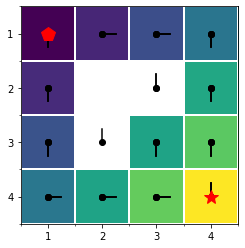

In [5]:
world = World('small')
paramSet = world.getParamSet()
model = initGridworld(paramSet)
v,pi = qLearn(model,1000,50000,.1,.1)
plotVP(v,pi,paramSet)
GridLine(paramSet['colCount'],paramSet['rowCount'])

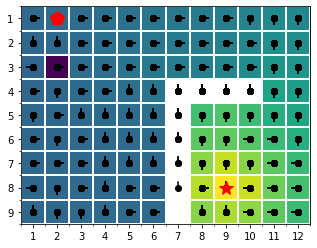

In [6]:
world = World('grid')
paramSet = world.getParamSet()
model = initGridworld(paramSet)
v,pi = qLearn(model,1000,50000,.1,.1)
plotVP(v,pi,paramSet)
GridLine(paramSet['colCount'],paramSet['rowCount'])

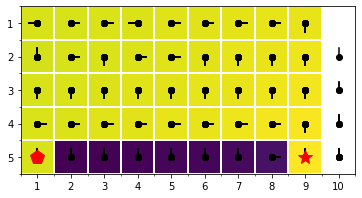

In [7]:
world = World('cliff')
paramSet = world.getParamSet()
model = initGridworld(paramSet)
v,pi = qLearn(model,1000,50000,.1,.1)
plotVP(v,pi,paramSet)
GridLine(paramSet['colCount'],paramSet['rowCount'])